# Data

In [1]:
import pickle
import numpy as np
import pandas as pd
import sqlite3
from tqdm import tqdm
from sklearn.model_selection import RepeatedStratifiedKFold

with open('../../pickles/swarog_data/swarog_bertcls.pickle', 'rb') as handle:
    swarog = pickle.load(handle)  
    
con = sqlite3.connect('../../pickles/swarog_data/swarog.sqlite')

In [3]:
swarog.shape

(186477, 768)

In [2]:
DATA_y = pd.read_sql_query("""
select 
label
from raw 
""",con)["label"].values

DATA_x = swarog

In [3]:
category_range = pd.read_sql_query("""
select 
min(rowid-1) as low, 
max(rowid-1) as hi, 
count(*) as size,
sum(label) as fake,
-1*sum(label-1) as real,
dataset
from raw 
group by dataset
order by low
""",con)
category_range

,low,hi,size,fake,real,dataset
0,0,8971,8972,8511,461,covid_fake_news
1,8972,16303,7332,2028,5304,mmcovid_en
2,16304,26378,10075,6306,3769,pubhealth
3,26379,77648,51270,5736,45534,qprop
4,77649,122546,44898,23481,21417,isot
5,122547,186476,63930,12999,50931,grafn


# Common Utils

## Metrics

In [4]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from imblearn.metrics import geometric_mean_score


class Metrics:
    def __init__(self):
        self.scores = {
            'Accuracy': {'func': accuracy_score},
            'Balanced Accuracy': {'func': balanced_accuracy_score},
            'F1': {'func': f1_score},
            'Precision': {'func': precision_score},
            'Recall': {'func': recall_score},
            'G-mean': {'func': geometric_mean_score}
        }
        
        for score_name, score_dict in self.scores.items():
            score_dict["list"] = []
            score_dict["lab"] = []

    def update(self, actual, prediction):
        for score_name, score_dict in self.scores.items():
            if score_name in ["F1","Precision","Recall","G-mean"]:
                scorvaln = score_dict['func'](actual, prediction, average=None)
                score_dict['lab'].append(scorvaln)
                scorval = score_dict['func'](actual, prediction, average="weighted")
                score_dict['list'].append(scorval)
                #print(score_name, scorval, scorvaln)  
            else:
                scorval=score_dict['func'](actual, prediction)
                score_dict['list'].append(scorval)
                
    def print_table(self, labels=None):
        # Print stats
        scores = self.scores
        numlabels = scores["F1"]["lab"][0].shape[0]
        scores["F1"]["lab"][0].shape[0] 
        head = "  %-20s  %-10s  " +  numlabels * " %-10s  " 
        headv = ["Score", "Average"]
        if labels:
            headv.extend([labels[i] for i in range(numlabels)])
        else:
            headv.extend(["Kat_"+str(i+1) for i in range(numlabels)])
        row=head % tuple(headv)
        # table header
        print("―"*len(row))
        print(row)
        print("―"*len(row))
        # table rows
        for score_name, score_dict in sorted(scores.items()) :
            headv = [score_name, np.mean(score_dict['list'])*100, np.std(score_dict['list'])*100]
            for i in range(numlabels):
                if score_name in ["F1","Precision","Recall", "G-mean"]:
                    head = "  %-20s  %4.1f ± %4.1f  " + numlabels* "%4.1f ± %4.1f  "
                    vals = [v[i] for v in scores[score_name]["lab"]]
                    headv.append(np.mean(vals)*100)
                    headv.append(np.std(vals)*100)
                else:
                    head = "  %-20s  %4.1f ± %4.1f  " + numlabels * "%-11s  " 
                    headv.append("-")
            print(head % tuple(headv))
        print("―"*len(row))

## Neural Model

In [5]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.autograd import Variable

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


def get_param(param, key, default):
    if key in param:
        return param[key]
    else:
        return default

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        n_input, n_hidden, n_hidden2, n_out = 768, 256, 128, 2

        self.ann_stack = nn.Sequential(
          nn.Linear(n_input, n_hidden),
          nn.ReLU(),
          nn.Linear(n_hidden, n_out),
        )
        
    def forward(self, x):
        return self.ann_stack(x)
    
class NeuralNetwork2(nn.Module):
    def __init__(self):
        super(NeuralNetwork2, self).__init__()
        n_input, n_hidden, n_out = 768, 256, 2
        
        self.ann_stack = nn.Sequential(
          nn.Linear(n_input, n_hidden),
          nn.ReLU(),
          nn.Linear(n_hidden, 128), 
          nn.ReLU(),
          nn.Linear(128, 64), 
          nn.ReLU(),
          nn.Linear(64, n_out), 
          nn.Softmax(dim=0)
        )
        
    def forward(self, x):
        return self.ann_stack(x)

def train_net(npdata_x, npdata_y, params={}):
    batch_size = get_param(params,"batch_size", 1024)
    learning_rate = get_param(params,"learning_rate", 0.001)
    epochs = get_param(params,"epochs", 80)
    showplots = get_param(params,"showplots", 0)
    model = get_param(params,"model", NeuralNetwork())
    loss_fn = get_param(params,"loss", nn.CrossEntropyLoss)
    optimizer = get_param(params,"optimizer", optim.Adam)
    
    batch_no = 1 + npdata_x.shape[0] // batch_size
    
    criterion = loss_fn()
    optimizer = optimizer(model.parameters(), lr=learning_rate)
    
    losses = []
    
    for epoch in range(epochs):
        running_loss = 0.0
        for i in range(batch_no):
            start = i * batch_size
            end = start + batch_size
            x_batch = Variable(torch.from_numpy(npdata_x[start:end]).to(device))
            y_batch = Variable(torch.from_numpy(npdata_y[start:end]).to(device))
        
            optimizer.zero_grad()
            y_preds = model(x_batch)
            #loss = criterion(y_preds, torch.unsqueeze(y_batch,dim=1))
            loss = criterion(y_preds, y_batch)
           
            loss.backward()
            optimizer.step()
            running_loss+=loss.item()
            
        losses.append(running_loss)
        
        #if epoch % 50 == 0: 
        #     print("Epoch {}, Loss: {}".format(epoch, running_loss))
    
    if showplots == 1:
        plt.plot(losses)
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.title("Learning rate %f"%(learning_rate))
        plt.show()
    return model

Using cuda device


## Experiment setup

In [58]:
from sklearn.linear_model import LogisticRegression

def experiment_shallow_lr(train, test, metrics):
    lr = LogisticRegression(max_iter=1000)
    lr.fit(train[0], train[1]) 
    ypred = lr.predict(test[0])
    metrics.update(test[1], ypred)
    return lr 

def experiment_ann(train, test, metrics, params={}):
    model = train_net(train[0], train[1], params)
    model_resp = model(torch.from_numpy(test[0]).to(device))
    y_pred_softmax = torch.log_softmax(model_resp, dim=1)
    _, label_as_ints = torch.max(y_pred_softmax, dim = 1)
    ypred = label_as_ints.cpu().detach().numpy()
    metrics.update(test[1], ypred)
    return model

def experiment_ann_no_learning(test, metrics, params):
    model = params["model"]
    model_resp = model(torch.from_numpy(test[0]).to(device))
    y_pred_softmax = torch.log_softmax(model_resp, dim=1)
    _, label_as_ints = torch.max(y_pred_softmax, dim = 1)
    ypred = label_as_ints.cpu().detach().numpy()
    metrics.update(test[1], ypred)
    return model

def experiment_vote_no_learning(test, metrics, params):
    ypred = []
    for vec in test[0]:
        category = np.argmax(vec[:6])
        start=6+category*2
        pred = np.argmax(vec[start:start+2])
        ypred.append(pred)
        
    metrics.update(test[1], ypred)
    
experiment = experiment_ann

In [8]:
rskf = RepeatedStratifiedKFold(n_splits=2, n_repeats=5, random_state=1410)
domain_models={}
rowiter = list(category_range.iterrows())

# Single Domain Models

## covid_fake_news

In [184]:
_id, row = rowiter[0]
print("DATASET",row["dataset"])
lo, hi = row["low"],row["hi"]
x = DATA_x[lo:hi+1]
y = DATA_y[lo:hi+1]
m = Metrics()

params = {
"batch_size":1024, 
"learning_rate":0.01, 
"epochs":30, 
"showplots":0,
"model": NeuralNetwork().to(device)
}

for fold_idx, (train, test) in enumerate(rskf.split(x, y)):
    model = experiment( (x[train],y[train]), (x[test],y[test]), m, params)
    domain_models[row["dataset"]] = model
m.print_table()

DATASET covid_fake_news
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  Score                 Average      Kat_1        Kat_2       
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  Accuracy              98.1 ±  0.8  -            -            
  Balanced Accuracy     87.3 ±  8.6  -            -            
  F1                    98.0 ±  1.0  79.2 ± 11.7  99.0 ±  0.4  
  G-mean                86.1 ± 10.3  85.8 ± 10.7  85.8 ± 10.7  
  Precision             98.1 ±  0.9  87.1 ±  7.3  98.7 ±  0.9  
  Recall                98.1 ±  0.8  75.2 ± 17.3  99.3 ±  0.5  
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


## mmcovid_en

In [188]:
_id, row = rowiter[1]
print("DATASET",row["dataset"])
lo, hi = row["low"],row["hi"]
x = DATA_x[lo:hi+1]
y = DATA_y[lo:hi+1]
m = Metrics()

params = {
"batch_size":1024, 
"learning_rate":0.01, 
"epochs":30, 
"showplots":0,
"model": NeuralNetwork().to(device),
"optimizer": optim.Adam
}

for fold_idx, (train, test) in enumerate(rskf.split(x, y)):
    model = experiment( (x[train],y[train]), (x[test],y[test]), m, params)
    domain_models[row["dataset"]] = model
m.print_table()

DATASET mmcovid_en
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  Score                 Average      Kat_1        Kat_2       
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  Accuracy              93.9 ±  1.3  -            -            
  Balanced Accuracy     90.1 ±  2.0  -            -            
  F1                    93.8 ±  1.4  95.9 ±  0.8  88.1 ±  2.7  
  G-mean                90.0 ±  2.1  89.7 ±  2.3  89.7 ±  2.3  
  Precision             94.0 ±  1.2  93.3 ±  1.3  95.9 ±  1.8  
  Recall                93.9 ±  1.3  98.7 ±  0.6  81.5 ±  3.9  
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


## pubhealth

In [189]:
_id, row = rowiter[2]
print("DATASET",row["dataset"])
lo, hi = row["low"],row["hi"]
x = DATA_x[lo:hi+1]
y = DATA_y[lo:hi+1]
m = Metrics()

params = {
"batch_size":1024, 
"learning_rate":0.01, 
"epochs":30, 
"showplots":0,
"model": NeuralNetwork().to(device)
}

for fold_idx, (train, test) in enumerate(rskf.split(x, y)):
    model = experiment( (x[train],y[train]), (x[test],y[test]), m, params)
    domain_models[row["dataset"]] = model
m.print_table()

DATASET pubhealth
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  Score                 Average      Kat_1        Kat_2       
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  Accuracy              84.8 ±  2.0  -            -            
  Balanced Accuracy     84.1 ±  2.2  -            -            
  F1                    84.8 ±  2.0  79.9 ±  2.6  87.7 ±  1.6  
  G-mean                84.1 ±  2.2  84.0 ±  2.3  84.0 ±  2.3  
  Precision             85.0 ±  1.9  79.0 ±  3.3  88.6 ±  2.2  
  Recall                84.8 ±  2.0  81.2 ±  4.4  86.9 ±  2.8  
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


## qprop

In [190]:
_id, row = rowiter[3]
print("DATASET",row["dataset"])
lo, hi = row["low"],row["hi"]
x = DATA_x[lo:hi+1]
y = DATA_y[lo:hi+1]
m = Metrics()

params = {
"batch_size":1024, 
"learning_rate":0.01, 
"epochs":30, 
"showplots":0,
"model": NeuralNetwork().to(device)
}

for fold_idx, (train, test) in enumerate(rskf.split(x, y)):
    model = experiment( (x[train],y[train]), (x[test],y[test]), m, params)
    domain_models[row["dataset"]] = model
m.print_table()

DATASET qprop
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  Score                 Average      Kat_1        Kat_2       
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  Accuracy              91.8 ±  0.7  -            -            
  Balanced Accuracy     83.2 ±  1.4  -            -            
  F1                    92.1 ±  0.6  95.3 ±  0.4  66.3 ±  2.5  
  G-mean                82.8 ±  1.5  82.5 ±  1.6  82.5 ±  1.6  
  Precision             92.5 ±  0.6  96.4 ±  0.3  61.4 ±  2.7  
  Recall                91.8 ±  0.7  94.3 ±  0.5  72.2 ±  2.5  
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


## isot

In [192]:
_id, row = rowiter[4]
print("DATASET",row["dataset"])
lo, hi = row["low"],row["hi"]
x = DATA_x[lo:hi+1]
y = DATA_y[lo:hi+1]
m = Metrics()

params = {
"batch_size":1024, 
"learning_rate":0.001, 
"epochs":30, 
"showplots":0,
"model": NeuralNetwork().to(device)
}

for fold_idx, (train, test) in enumerate(rskf.split(x, y)):
    model = experiment( (x[train],y[train]), (x[test],y[test]), m, params)
    domain_models[row["dataset"]] = model
m.print_table()

DATASET isot
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  Score                 Average      Kat_1        Kat_2       
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  Accuracy              98.7 ±  1.1  -            -            
  Balanced Accuracy     98.7 ±  1.1  -            -            
  F1                    98.7 ±  1.1  98.7 ±  1.2  98.8 ±  1.1  
  G-mean                98.7 ±  1.1  98.7 ±  1.1  98.7 ±  1.1  
  Precision             98.7 ±  1.1  98.3 ±  1.5  99.2 ±  0.8  
  Recall                98.7 ±  1.1  99.1 ±  0.9  98.4 ±  1.4  
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


## grafn

In [196]:
_id, row = rowiter[5]
print("DATASET",row["dataset"])
lo, hi = row["low"],row["hi"]
x = DATA_x[lo:hi+1]
y = DATA_y[lo:hi+1]
m = Metrics()

params = {
"batch_size":1024, 
"learning_rate":0.001, 
"epochs":60, 
"showplots":0,
"model": NeuralNetwork().to(device)
}

for fold_idx, (train, test) in enumerate(rskf.split(x, y)):
    model = experiment( (x[train],y[train]), (x[test],y[test]), m, params)
    domain_models[row["dataset"]] = model
    #m.print_table()
m.print_table()

DATASET grafn
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  Score                 Average      Kat_1        Kat_2       
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  Accuracy              89.1 ±  1.2  -            -            
  Balanced Accuracy     77.7 ±  3.2  -            -            
  F1                    88.3 ±  1.5  93.4 ±  0.6  68.4 ±  5.1  
  G-mean                76.9 ±  3.6  75.2 ±  4.4  75.2 ±  4.4  
  Precision             88.7 ±  1.2  90.2 ±  1.3  82.7 ±  1.0  
  Recall                89.1 ±  1.2  96.9 ±  0.3  58.6 ±  6.5  
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


# Document Category Classifier

In [9]:
rskf = RepeatedStratifiedKFold(n_splits=2, n_repeats=5, random_state=1410)

class NNCategoryPredictor(nn.Module):
    def __init__(self, nocategories=6):
        super(NNCategoryPredictor, self).__init__()
        n_input, n_hidden, n_out = 768, 256, nocategories

        self.ann_stack = nn.Sequential(
          nn.Linear(n_input, n_hidden),
          nn.ReLU(),
          nn.Linear(n_hidden, 128), 
          nn.ReLU(),
          nn.Linear(128, nocategories)
        )
        
    def forward(self, x): 
        return self.ann_stack(x)
    
    
params = {
"batch_size":15*1024, 
"learning_rate":0.0008, 
"epochs":580, 
"showplots":0,
"model": NNCategoryPredictor().to(device)
}


m = Metrics()   
for foldid in range(10):
    #print("fold",foldid)
    X_train=[]
    X_test=[]
    y_train=[]
    y_test=[]
    
    for index, row in category_range.iterrows():
        lo, hi = row["low"],row["hi"]
        x = np.array(list(range(lo,hi+1)))
        y = DATA_y[lo:hi+1]
        train, test = list(rskf.split(x, y))[foldid]
        X_train.extend(x[train])
        y_train.extend([index for nu in range(len(train))])
        X_test.extend(x[test])
        y_test.extend([index for nu in range(len(test))])
        #print(lo, hi, "|", min(x[train]), max(x[train]),"|", min(x[test]), max(x[test]))
    
    category_model = experiment( (DATA_x[X_train],np.array(y_train)), (DATA_x[X_test],np.array(y_test)), m, params)
    # lr.fit(DATA_x[X_train],y_train) 
    # ypred = lr.predict(DATA_x[X_test])
    # m.update(y_test, ypred)
    #m.print_table() 
    
m.print_table()    

KeyboardInterrupt: 

# Stitching

## Transforming data

In [112]:
import pickle

In [175]:
nn.Sequential(*list(domain_models["covid_fake_news"].ann_stack.children())[:])

Sequential(
  (0): Linear(in_features=1664, out_features=1024, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1024, out_features=512, bias=True)
  (3): ReLU()
  (4): Linear(in_features=512, out_features=2, bias=True)
)

In [197]:
new_data=[]
for index, row in category_range.iterrows():
    print("DATASET",row["dataset"])
    lo, hi = row["low"],row["hi"]
    x = DATA_x[lo:hi+1]
    category_model_neck = nn.Sequential(*list(category_model.ann_stack.children())[:]).to(device)
    toch_x = torch.from_numpy(x).to(device)
    newx = category_model_neck(toch_x).cpu().detach().numpy()
    print(newx.shape)
    
    for domain_model_name in ["covid_fake_news","mmcovid_en","pubhealth","qprop","isot","grafn"]:
        model_neck = nn.Sequential(*list(domain_models[domain_model_name].ann_stack.children())[:]).to(device)
        new_domain_x = model_neck(toch_x).cpu().detach().numpy()
        print("  ",new_domain_x.shape)
        newx = np.hstack((newx,new_domain_x))
    
    new_data.extend(newx)
    print(newx.shape, 128 + 256*5)   
    
f = open('new_data.pkl', 'wb')
pickle.dump(np.array(new_data), f, protocol=pickle.HIGHEST_PROTOCOL)
f.close()

DATASET covid_fake_news
(8972, 6)
   (8972, 2)
   (8972, 2)
   (8972, 2)
   (8972, 2)
   (8972, 2)
   (8972, 2)
(8972, 18) 1408
DATASET mmcovid_en
(7332, 6)
   (7332, 2)
   (7332, 2)
   (7332, 2)
   (7332, 2)
   (7332, 2)
   (7332, 2)
(7332, 18) 1408
DATASET pubhealth
(10075, 6)
   (10075, 2)
   (10075, 2)
   (10075, 2)
   (10075, 2)
   (10075, 2)
   (10075, 2)
(10075, 18) 1408
DATASET qprop
(51270, 6)
   (51270, 2)
   (51270, 2)
   (51270, 2)
   (51270, 2)
   (51270, 2)
   (51270, 2)
(51270, 18) 1408
DATASET isot
(44898, 6)
   (44898, 2)
   (44898, 2)
   (44898, 2)
   (44898, 2)
   (44898, 2)
   (44898, 2)
(44898, 18) 1408
DATASET grafn
(63930, 6)
   (63930, 2)
   (63930, 2)
   (63930, 2)
   (63930, 2)
   (63930, 2)
   (63930, 2)
(63930, 18) 1408


In [10]:
with open('new_data.pkl', 'rb') as handle:
    new_data = pickle.load(handle)
new_data.shape, DATA_x.shape

((186477, 18), (186477, 768))

## Final model

In [67]:
rskf = RepeatedStratifiedKFold(n_splits=2, n_repeats=5, random_state=1410)

class StitchingHead(nn.Module):
    def __init__(self, nocategories=6):
        super(StitchingHead, self).__init__()
        n_input, n_hidden, n_hidden2, n_out = 18, 1024, 512, 2

        self.ann_stack = nn.Sequential(
          nn.Linear(n_input, 128),
          nn.ReLU(),
          nn.Linear(128, 64), 
          nn.ReLU(),
          nn.Linear(64, n_out)
        )
        
    def forward(self, x): 
        return self.ann_stack(x)


### single FC on top

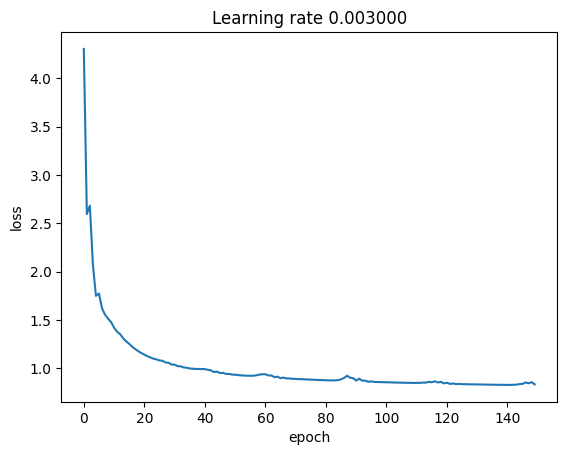

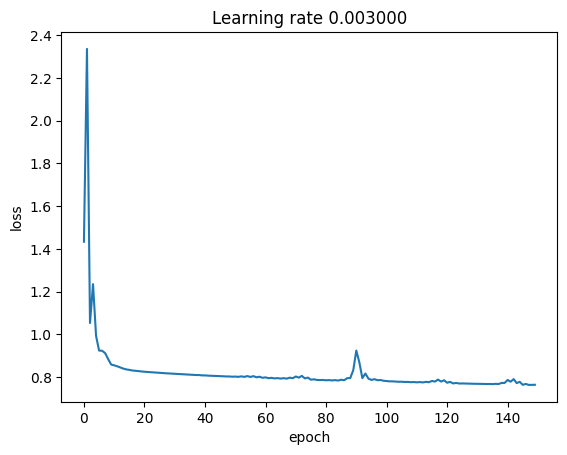

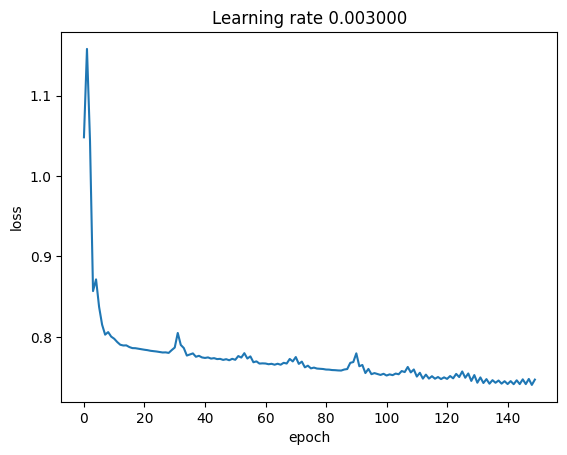

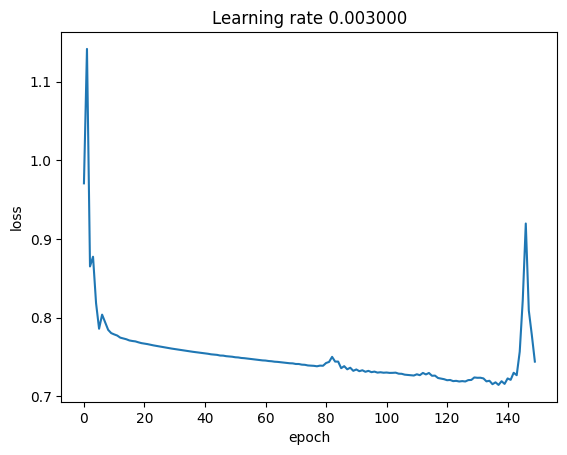

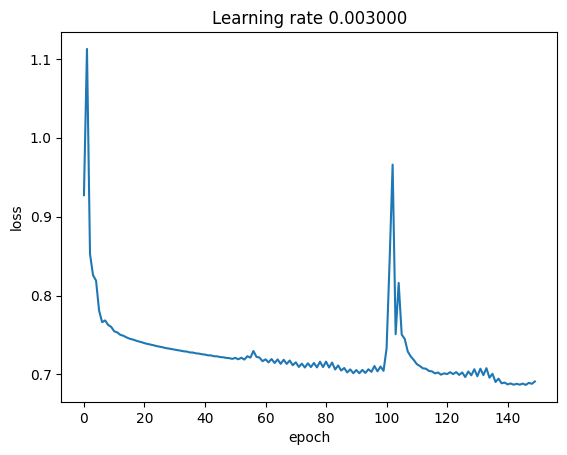

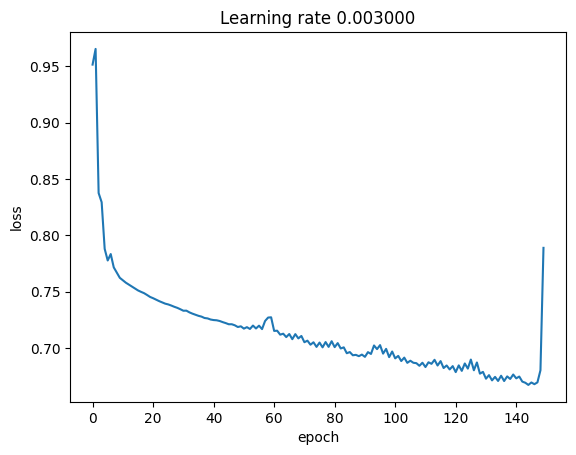

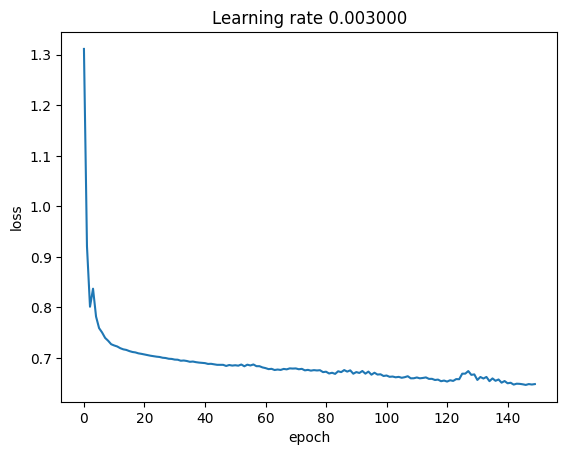

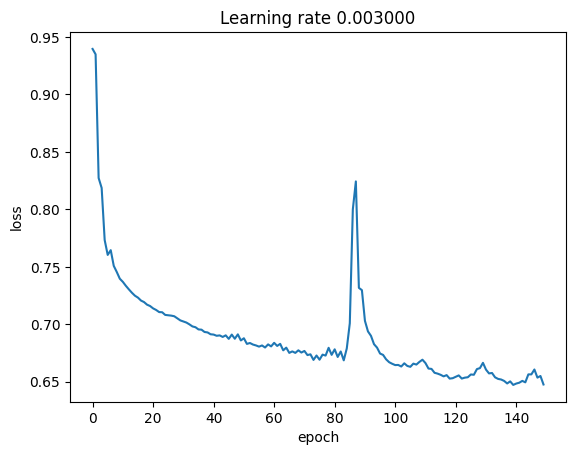

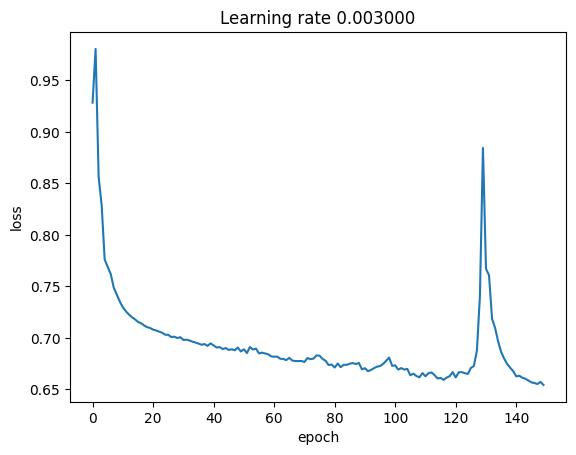

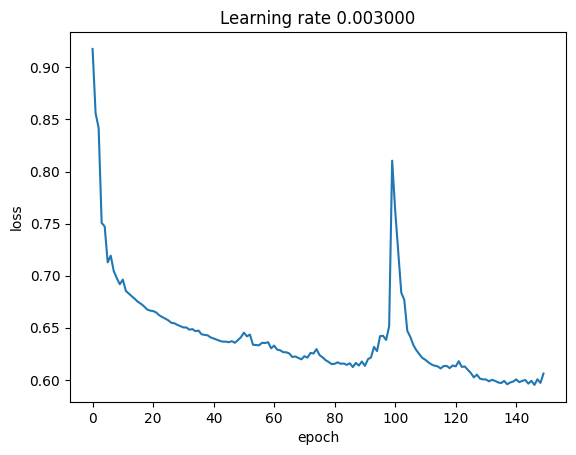

FC learning stats
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  Score                 Average      Kat_1        Kat_2       
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  Accuracy              93.3 ±  0.4  -            -            
  Balanced Accuracy     91.6 ±  0.4  -            -            
  F1                    93.2 ±  0.4  95.1 ±  0.3  89.1 ±  0.5  
  G-mean                91.6 ±  0.4  91.5 ±  0.4  91.5 ±  0.4  
  Precision             93.3 ±  0.4  94.1 ±  0.4  91.5 ±  1.4  
  Recall                93.3 ±  0.4  96.2 ±  0.7  86.9 ±  1.1  
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
 
DATASET covid_fake_news
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  Score                 Average      Kat_1        Kat_2       
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  Accuracy              99.5 ±  0.2  -            -            
  Balanced Accuracy     97.2 ±  1.2  -            -            
  F

In [69]:
m = Metrics()   

params = {
"batch_size":20*1024, 
"learning_rate":0.003, 
"epochs":150, 
"showplots":1,
"model": StitchingHead().to(device)
}

# Train Neural model on whole training data

for foldid in range(10):
    X_train=[]
    X_test=[]
    y_train=[]
    y_test=[]
    
    for index, row in category_range.iterrows():
        lo, hi = row["low"],row["hi"]
        x = np.array(list(range(lo,hi+1)))
        y = DATA_y[lo:hi+1]
        train, test = list(rskf.split(x, y))[foldid]
        X_train.extend(x[train])
        y_train.extend(y[train])
        X_test.extend(x[test])
        y_test.extend(y[test])
    final_model = experiment( (new_data[X_train],np.array(y_train)), (new_data[X_test],np.array(y_test)), m, params)

print("FC learning stats")
m.print_table()  

print(" ")

# check dataset one by one

m = Metrics()   
for mid in range(6):
    _id, row = rowiter[mid]
    print("DATASET",row["dataset"])
    lo, hi = row["low"],row["hi"]
    x = new_data[lo:hi+1]
    y = DATA_y[lo:hi+1]
    m = Metrics()

    params = {
    "model": final_model
    }

    for fold_idx, (train, test) in enumerate(rskf.split(x, y)):
        experiment_ann_no_learning( (x[test],y[test]), m, params)
    m.print_table()

### Voting

In [59]:
m = Metrics()   
for mid in range(6):
    _id, row = rowiter[mid]
    print("DATASET",row["dataset"])
    lo, hi = row["low"],row["hi"]
    x = new_data[lo:hi+1]
    y = DATA_y[lo:hi+1]
    m = Metrics()

    params = {
    "model": final_model
    }

    for fold_idx, (train, test) in enumerate(rskf.split(x, y)):
        experiment_vote_no_learning( (x[test],y[test]), m, params)
    m.print_table()

DATASET covid_fake_news
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  Score                 Average      Kat_1        Kat_2       
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  Accuracy              99.4 ±  0.3  -            -            
  Balanced Accuracy     97.7 ±  1.0  -            -            
  F1                    99.4 ±  0.3  94.3 ±  2.4  99.7 ±  0.1  
  G-mean                97.7 ±  1.0  97.7 ±  1.0  97.7 ±  1.0  
  Precision             99.4 ±  0.2  92.7 ±  3.0  99.8 ±  0.1  
  Recall                99.4 ±  0.3  95.9 ±  1.9  99.6 ±  0.2  
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
DATASET mmcovid_en
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  Score                 Average      Kat_1        Kat_2       
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  Accuracy              94.9 ±  0.5  -            -            
  Balanced Accuracy     91.3 ±  0.9  -            -            
  F1

# Evaluation

In [28]:
stiched_domain_models={}
final_model = StitchingHead().to(device)

## covid_fake_news

In [51]:
_id, row = rowiter[0]
print("DATASET",row["dataset"])
lo, hi = row["low"],row["hi"]
x = new_data[lo:hi+1]
y = DATA_y[lo:hi+1]
m = Metrics()

params = {
"batch_size":1024, 
"learning_rate":0.001, 
"epochs":80, 
"showplots":0,
"model": StitchingHead().to(device)
}

for fold_idx, (train, test) in enumerate(rskf.split(x, y)):
    model = experiment( (x[train],y[train]), (x[test],y[test]), m, params)
    stiched_domain_models[row["dataset"]] = model
m.print_table()

DATASET covid_fake_news
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  Score                 Average      Kat_1        Kat_2       
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  Accuracy              99.6 ±  0.1  -            -            
  Balanced Accuracy     98.0 ±  0.7  -            -            
  F1                    99.6 ±  0.1  96.4 ±  0.8  99.8 ±  0.0  
  G-mean                98.0 ±  0.7  98.0 ±  0.7  98.0 ±  0.7  
  Precision             99.6 ±  0.1  96.5 ±  1.0  99.8 ±  0.1  
  Recall                99.6 ±  0.1  96.3 ±  1.4  99.8 ±  0.1  
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


## mmcovid_en

In [52]:
_id, row = rowiter[1]
print("DATASET",row["dataset"])
lo, hi = row["low"],row["hi"]
x = new_data[lo:hi+1]
y = DATA_y[lo:hi+1]
m = Metrics()

params = {
"batch_size":1024, 
"learning_rate":0.001, 
"epochs":80, 
"showplots":0,
"model": StitchingHead().to(device)
}

for fold_idx, (train, test) in enumerate(rskf.split(x, y)):
    model = experiment( (x[train],y[train]), (x[test],y[test]), m, params)
    stiched_domain_models[row["dataset"]] = model
m.print_table()

DATASET mmcovid_en
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  Score                 Average      Kat_1        Kat_2       
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  Accuracy              95.6 ±  0.4  -            -            
  Balanced Accuracy     92.7 ±  0.9  -            -            
  F1                    95.5 ±  0.5  97.1 ±  0.3  91.6 ±  1.0  
  G-mean                92.7 ±  0.9  92.5 ±  0.9  92.5 ±  0.9  
  Precision             95.7 ±  0.4  94.9 ±  0.6  97.8 ±  0.6  
  Recall                95.6 ±  0.4  99.3 ±  0.2  86.1 ±  1.8  
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


## pubhealth

In [216]:
_id, row = rowiter[2]
print("DATASET",row["dataset"])
lo, hi = row["low"],row["hi"]
x = new_data[lo:hi+1]
y = DATA_y[lo:hi+1]
m = Metrics()

params = {
"batch_size":1024, 
"learning_rate":0.002, 
"epochs":80,
"showplots":0,
"model": StitchingHead().to(device)
}

for fold_idx, (train, test) in enumerate(rskf.split(x, y)):
    model = experiment( (x[train],y[train]), (x[test],y[test]), m, params)
    stiched_domain_models[row["dataset"]] = model
m.print_table()

DATASET pubhealth
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  Score                 Average      Kat_1        Kat_2       
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  Accuracy              88.4 ±  0.5  -            -            
  Balanced Accuracy     88.2 ±  0.6  -            -            
  F1                    88.5 ±  0.5  84.9 ±  0.7  90.6 ±  0.4  
  G-mean                88.2 ±  0.6  88.1 ±  0.6  88.1 ±  0.6  
  Precision             88.6 ±  0.6  82.8 ±  0.6  92.1 ±  0.6  
  Recall                88.4 ±  0.5  87.2 ±  1.0  89.1 ±  0.4  
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


## qprop

In [217]:
_id, row = rowiter[3]
print("DATASET",row["dataset"])
lo, hi = row["low"],row["hi"]
x = new_data[lo:hi+1]
y = DATA_y[lo:hi+1]
m = Metrics()

params = {
"batch_size":1024, 
"learning_rate":0.001, 
"epochs":80,
"showplots":0,
"model": StitchingHead().to(device)
}

for fold_idx, (train, test) in enumerate(rskf.split(x, y)):
    model = experiment( (x[train],y[train]), (x[test],y[test]), m, params)
    stiched_domain_models[row["dataset"]] = model
m.print_table()

DATASET qprop
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  Score                 Average      Kat_1        Kat_2       
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  Accuracy              93.0 ±  0.2  -            -            
  Balanced Accuracy     83.0 ±  1.0  -            -            
  F1                    93.0 ±  0.2  96.1 ±  0.1  69.1 ±  1.1  
  G-mean                82.3 ±  1.1  81.9 ±  1.2  81.9 ±  1.2  
  Precision             93.1 ±  0.2  96.2 ±  0.2  68.3 ±  0.7  
  Recall                93.0 ±  0.2  95.9 ±  0.2  70.0 ±  2.1  
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


## isot

In [218]:
_id, row = rowiter[4]
print("DATASET",row["dataset"])
lo, hi = row["low"],row["hi"]
x = new_data[lo:hi+1]
y = DATA_y[lo:hi+1]
m = Metrics()

params = {
"batch_size":1024, 
"learning_rate":0.001, 
"epochs":80,
"showplots":0,
"model": StitchingHead().to(device)
}

for fold_idx, (train, test) in enumerate(rskf.split(x, y)):
    model = experiment( (x[train],y[train]), (x[test],y[test]), m, params)
    stiched_domain_models[row["dataset"]] = model
m.print_table()

DATASET isot
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  Score                 Average      Kat_1        Kat_2       
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  Accuracy              99.7 ±  0.0  -            -            
  Balanced Accuracy     99.7 ±  0.0  -            -            
  F1                    99.7 ±  0.0  99.7 ±  0.0  99.7 ±  0.0  
  G-mean                99.7 ±  0.0  99.7 ±  0.0  99.7 ±  0.0  
  Precision             99.7 ±  0.0  99.7 ±  0.1  99.7 ±  0.1  
  Recall                99.7 ±  0.0  99.6 ±  0.1  99.7 ±  0.1  
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


## grafn

In [219]:
_id, row = rowiter[5]
print("DATASET",row["dataset"])
lo, hi = row["low"],row["hi"]
x = new_data[lo:hi+1]
y = DATA_y[lo:hi+1]
m = Metrics()

params = {
"batch_size":1024, 
"learning_rate":0.001, 
"epochs":80,
"showplots":0,
"model": StitchingHead().to(device)
}

for fold_idx, (train, test) in enumerate(rskf.split(x, y)):
    model = experiment( (x[train],y[train]), (x[test],y[test]), m, params)
    stiched_domain_models[row["dataset"]] = model
m.print_table()

DATASET grafn
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  Score                 Average      Kat_1        Kat_2       
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  Accuracy              90.3 ±  0.2  -            -            
  Balanced Accuracy     81.3 ±  0.4  -            -            
  F1                    89.9 ±  0.2  94.1 ±  0.1  73.5 ±  0.5  
  G-mean                80.8 ±  0.4  79.8 ±  0.5  79.8 ±  0.5  
  Precision             89.9 ±  0.2  91.8 ±  0.2  82.8 ±  0.3  
  Recall                90.3 ±  0.2  96.5 ±  0.1  66.1 ±  0.8  
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
